In [1]:
import pickle as pkl
import warnings
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import sklearn
import torch
from emle.models import EMLE
from emle.train._utils import pad_to_max

warnings.filterwarnings("ignore")
KJ_PER_MOL_TO_KCAL_PER_MOL = 1.0 / 4.184
HARTEE_TO_KJ_MOL = 2625.5

/home/joao/miniforge3/envs/fes-ml-aev/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.

In [2]:
def plot_performance_per_molecule(
    emle_energy_dict, molecules, output_filename, figsize=(20, 6)
):
    """
    Plot performance metrics for each molecule comparing EMLE vs QM/MM energies.

    Parameters
    ----------
    emle_energy_dict : dict
        Dictionary containing energy data for each molecule
    molecules : list
        List of molecule names
    output_filename : str
        Name of the output file to save the plot
    figsize : tuple, optional
        Figure size (width, height per molecule), by default (20, 6)
    """
    sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)
    fig, axes = plt.subplots(
        len(molecules), 3, figsize=(figsize[0], figsize[1] * len(molecules))
    )

    for i, mol in enumerate(molecules):
        total_emle = (
            emle_energy_dict[mol]["e_static_emle"] + emle_energy_dict[mol]["e_ind_emle"]
        )
        total_ref = (
            emle_energy_dict[mol]["e_static_ref"] + emle_energy_dict[mol]["e_ind_ref"]
        )
        total_ref = total_ref.detach().cpu().numpy()
        static_emle = emle_energy_dict[mol]["e_static_emle"]
        static_ref = emle_energy_dict[mol]["e_static_ref"].detach().cpu().numpy()
        ind_emle = emle_energy_dict[mol]["e_ind_emle"]
        ind_ref = emle_energy_dict[mol]["e_ind_ref"].detach().cpu().numpy()

        # Calculate RMSE
        rmse_total = np.sqrt(np.mean((total_emle - total_ref) ** 2))
        rmse_static = np.sqrt(np.mean((static_emle - static_ref) ** 2))
        rmse_ind = np.sqrt(np.mean((ind_emle - ind_ref) ** 2))

        xlim = ylim = (-75, 10)

        # Plot total interaction energy
        ax1 = axes[i, 0]
        ax1.plot([-1000, 1000], [-1000, 1000], color="black", linestyle="--")
        ax1.scatter(total_ref, total_emle, alpha=0.7, cmap="Blues")
        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)
        ax1.set_aspect("equal", adjustable="box")
        ax1.set_xlabel("$E^{QM/MM}_{int}$ [kcal.mol$^{-1}$]")
        ax1.set_ylabel("$E^{EMLE}_{int}$ [kcal.mol$^{-1}$]")
        ax1.set_title(f"{mol} (RMSE={rmse_total:.2f})")

        # Plot static energy
        ax2 = axes[i, 1]
        ax2.plot([-1000, 1000], [-1000, 1000], color="black", linestyle="--")
        ax2.scatter(static_ref, static_emle, alpha=0.7, cmap="Blues")
        ax2.set_xlim(xlim)
        ax2.set_ylim(ylim)
        ax2.set_aspect("equal", adjustable="box")
        ax2.set_xlabel("$E^{QM/MM}_{static}$ [kcal.mol$^{-1}$]")
        ax2.set_ylabel("$E^{EMLE}_{static}$ [kcal.mol$^{-1}$]")
        ax2.set_title(f"{mol} (RMSE={rmse_static:.2f})")

        # Plot induction energy
        ax3 = axes[i, 2]
        ax3.plot([-1000, 1000], [-1000, 1000], color="black", linestyle="--")
        ax3.scatter(ind_ref, ind_emle, alpha=0.7, cmap="Blues")
        ax3.set_xlim(xlim)
        ax3.set_ylim(ylim)
        ax3.set_aspect("equal", adjustable="box")
        ax3.set_xlabel("$E^{QM/MM}_{ind}$ [kcal.mol$^{-1}$]")
        ax3.set_ylabel("$E^{EMLE}_{ind}$ [kcal.mol$^{-1}$]")
        ax3.set_title(f"{mol} (RMSE={rmse_ind:.2f})")

    plt.subplots_adjust(hspace=0.3)
    plt.savefig(output_filename, bbox_inches="tight", dpi=300, transparent=True)
    return fig, axes

# EMLE Reference Data

In [3]:
# Set the path to the models
source_path = "../../../"

models_dict = {
    "General Model": source_path + "emle_models/emle_qm7_aev.mat",
    "Bespoke Model": source_path + "emle_models/ligand_bespoke_iter2.mat",
    "Patched Model": source_path + "emle_models/ligand_patched_species_iter2.mat",
}

# Load the testing data
molecules = [
    "n-pentane",
    "n-octane",
    "benzene",
    "naphthalene",
    "water",
    "methanol",
    "o-cresol",
    "aceticacid",
    "1_4-dioxane",
    "methylpentanoate",
    "methylbenzoate",
    "2-pentanone",
    "ethylphenylether",
    "m-hydroxybenzaldehyde",
    "acetonitrile",
    "pyridine",
    "aniline",
    "benzamide",
    "1-propanethiol",
    "thioanisole",
]

testing_data = {
    mol: pkl.load(
        open(
            f"/home/storage/joao/tip3p_final/bespoke_models/sampling_iter2/{mol}/{mol}.pkl",
            "rb",
        )
    )
    for mol in molecules
}
data_dict = {
    mol: {
        "xyz_qm": [],
        "xyz_mm": [],
        "z": [],
        "charges_mm": [],
        "e_static_ref": [],
        "e_ind_ref": [],
    }
    for mol in molecules
}


for mol in molecules:
    data_dict[mol]["xyz_qm"] = testing_data[mol]["xyz_qm"]
    data_dict[mol]["xyz_mm"] = testing_data[mol]["xyz_mm"]
    data_dict[mol]["z"] = testing_data[mol]["z"]
    data_dict[mol]["charges_mm"] = testing_data[mol]["charges_mm"]
    data_dict[mol]["e_static_ref"] = testing_data[mol]["e_static"]
    data_dict[mol]["e_ind_ref"] = testing_data[mol]["e_ind"]

# Pad to max and convert to torch tensors
for mol in molecules:
    data_dict[mol]["xyz_qm"] = pad_to_max(data_dict[mol]["xyz_qm"])
    data_dict[mol]["xyz_mm"] = pad_to_max(data_dict[mol]["xyz_mm"])
    data_dict[mol]["z"] = pad_to_max(data_dict[mol]["z"])
    data_dict[mol]["charges_mm"] = pad_to_max(data_dict[mol]["charges_mm"])
    data_dict[mol]["e_static_ref"] = torch.tensor(data_dict[mol]["e_static_ref"])
    data_dict[mol]["e_ind_ref"] = torch.tensor(data_dict[mol]["e_ind_ref"])

# Plot Per Molecule (General Model)

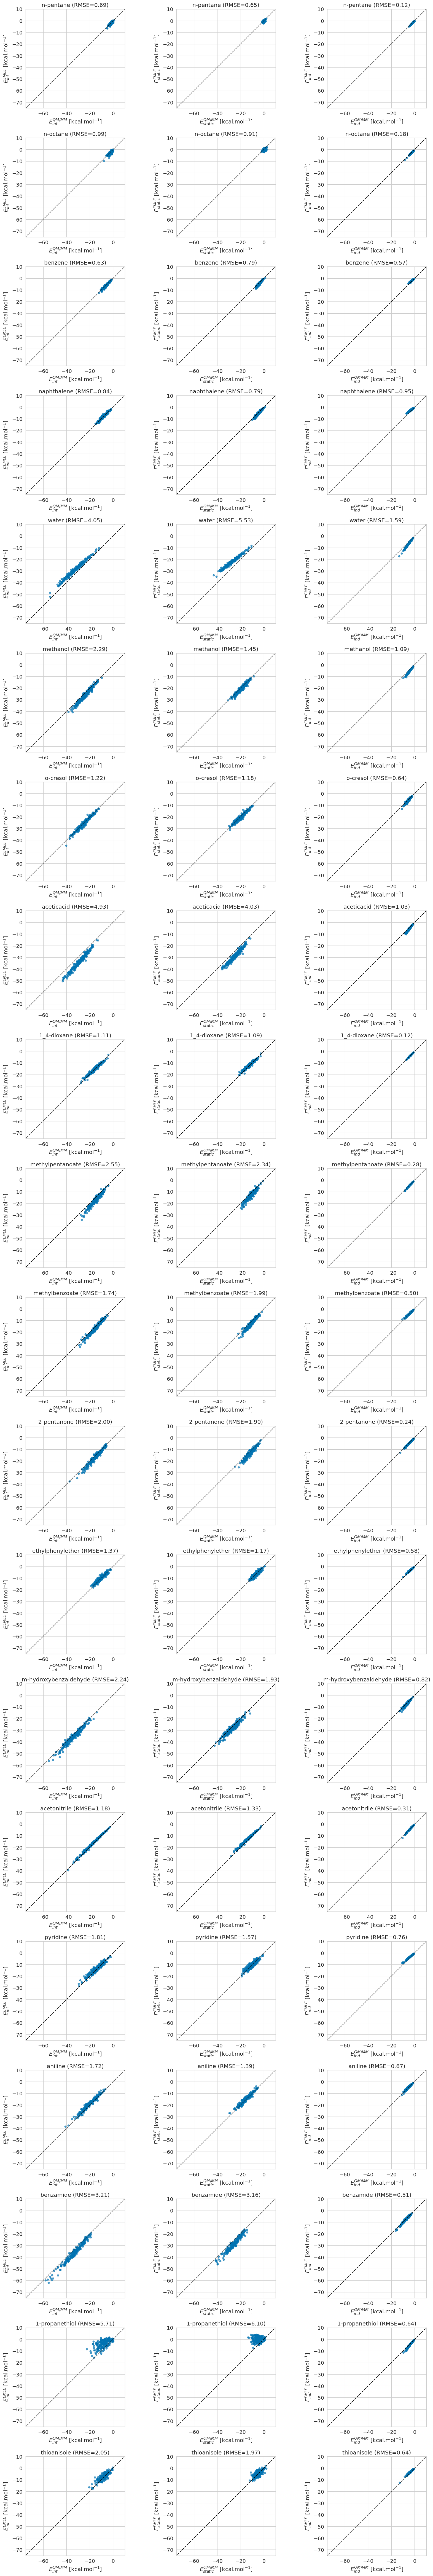

In [4]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}
model_path = models_dict["General Model"]
for mol in molecules:
    emle_model = EMLE(model=model_path, alpha_mode="species").double()

    e_static_emle, e_ind_emle = emle_model.forward(
        data_dict[mol]["z"],
        data_dict[mol]["charges_mm"],
        data_dict[mol]["xyz_qm"],
        data_dict[mol]["xyz_mm"],
    )

    e_static_emle = e_static_emle.detach().cpu().numpy()
    e_ind_emle = e_ind_emle.detach().cpu().numpy()

    emle_energy_dict[mol] = {
        "e_static_emle": e_static_emle * HARTEE_TO_KJ_MOL * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_ind_emle": e_ind_emle * HARTEE_TO_KJ_MOL * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_static_ref": data_dict[mol]["e_static_ref"] * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_ind_ref": data_dict[mol]["e_ind_ref"] * KJ_PER_MOL_TO_KCAL_PER_MOL,
    }

fig, axes = plot_performance_per_molecule(
    emle_energy_dict=emle_energy_dict,
    molecules=molecules,
    output_filename="fig_performance_per_molecule_general.pdf",
)

# Plot Per Molecule (Bespoke Model)

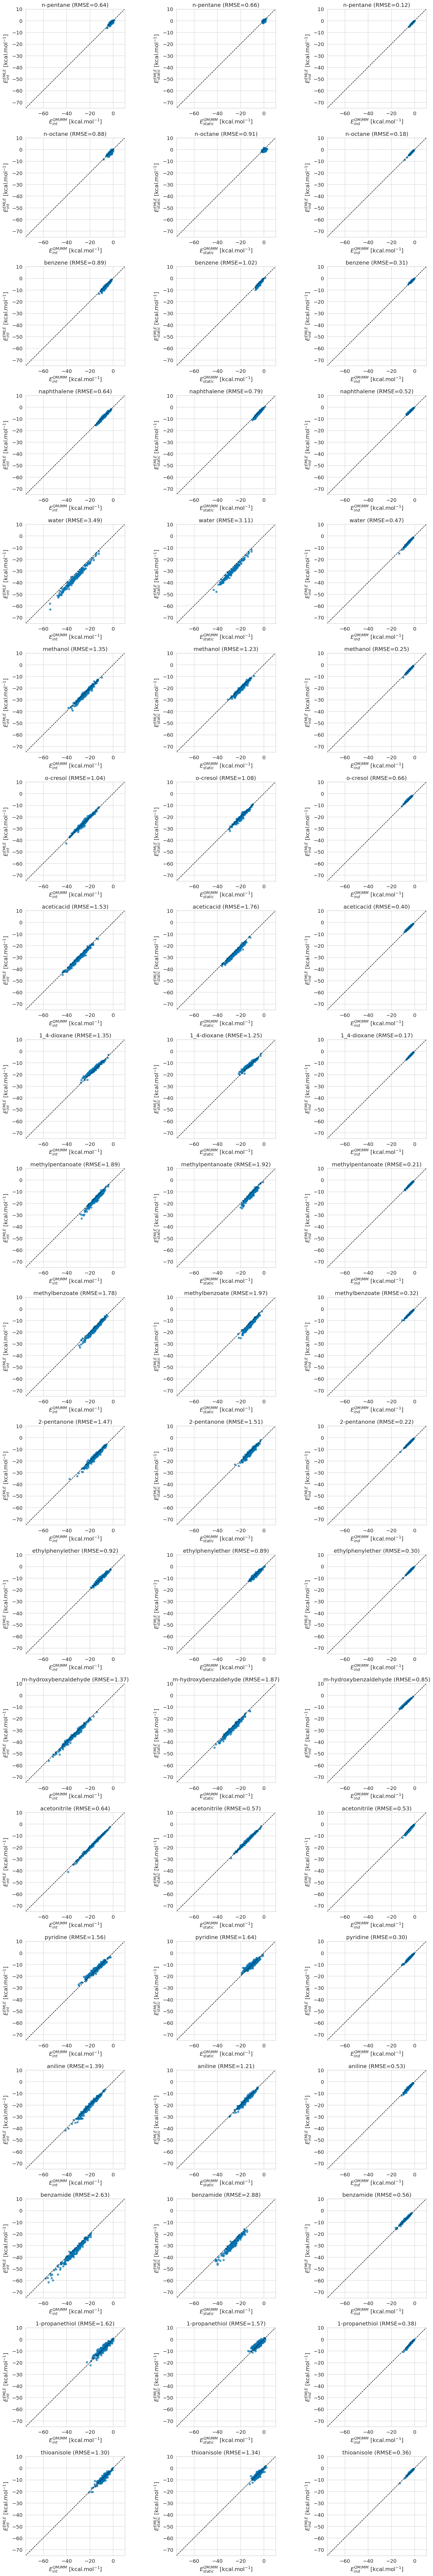

In [5]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}
model_path = models_dict["Bespoke Model"]
for mol in molecules:
    emle_model = EMLE(model=model_path, alpha_mode="species").double()

    e_static_emle, e_ind_emle = emle_model.forward(
        data_dict[mol]["z"],
        data_dict[mol]["charges_mm"],
        data_dict[mol]["xyz_qm"],
        data_dict[mol]["xyz_mm"],
    )

    e_static_emle = e_static_emle.detach().cpu().numpy()
    e_ind_emle = e_ind_emle.detach().cpu().numpy()

    emle_energy_dict[mol] = {
        "e_static_emle": e_static_emle * HARTEE_TO_KJ_MOL * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_ind_emle": e_ind_emle * HARTEE_TO_KJ_MOL * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_static_ref": data_dict[mol]["e_static_ref"] * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_ind_ref": data_dict[mol]["e_ind_ref"] * KJ_PER_MOL_TO_KCAL_PER_MOL,
    }

fig, axes = plot_performance_per_molecule(
    emle_energy_dict=emle_energy_dict,
    molecules=molecules,
    output_filename="fig_performance_per_molecule_bespoke.pdf",
    figsize=(20, 6),
)

# Plot Per Molecule (Patched Model)

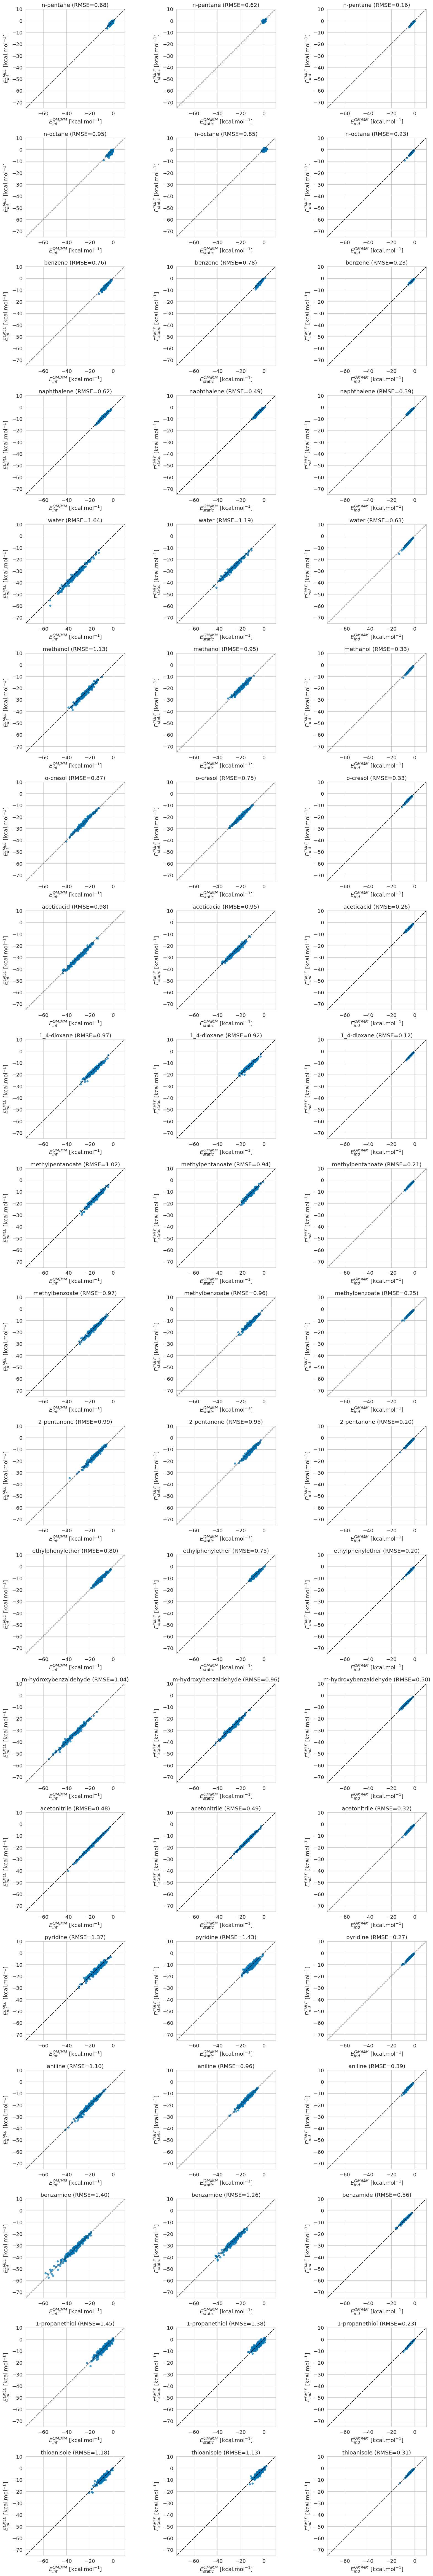

In [6]:
# Evaluate the EMLE energy for each model
emle_energy_dict = {}
model_path = models_dict["Patched Model"]
for mol in molecules:
    emle_model = EMLE(model=model_path, alpha_mode="species").double()

    e_static_emle, e_ind_emle = emle_model.forward(
        data_dict[mol]["z"],
        data_dict[mol]["charges_mm"],
        data_dict[mol]["xyz_qm"],
        data_dict[mol]["xyz_mm"],
    )

    e_static_emle = e_static_emle.detach().cpu().numpy()
    e_ind_emle = e_ind_emle.detach().cpu().numpy()

    emle_energy_dict[mol] = {
        "e_static_emle": e_static_emle * HARTEE_TO_KJ_MOL * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_ind_emle": e_ind_emle * HARTEE_TO_KJ_MOL * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_static_ref": data_dict[mol]["e_static_ref"] * KJ_PER_MOL_TO_KCAL_PER_MOL,
        "e_ind_ref": data_dict[mol]["e_ind_ref"] * KJ_PER_MOL_TO_KCAL_PER_MOL,
    }

fig, axes = plot_performance_per_molecule(
    emle_energy_dict=emle_energy_dict,
    molecules=molecules,
    output_filename="fig_performance_per_molecule_patched.pdf",
    figsize=(20, 6),
)